# antiquotadu

In [1]:
import json

# with open('antiquotadu/result.json') as f:
with open('sup/antiquotadu_discuss/result.json') as f:
    my_json = json.load(f)

In [2]:
import pandas as pd
my_keys = set()
emojis = set()
hashtags = set()
for message in my_json['messages']:
    if pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06"):
        my_keys = my_keys.union(set(message.keys()))
        if ('reactions' in message) and (len(message['reactions']) >0):
            for rxn in message['reactions']:
                if 'emoji' in rxn:
                    emojis.add(rxn['emoji'])
        if ('text_entities' in message) and (len(message['text_entities'] )> 0):
            hashtags = hashtags.union(set([i['text'] for i in message['text_entities'] if i['type']=='hashtag']))


In [3]:
import pandas as pd
from collections import defaultdict
import numpy as np

res_dict = defaultdict(list)
emoji_dict = defaultdict(list)
hashtag_dict = defaultdict(list)

for message in my_json['messages']:
    
    if (pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06")) and (pd.to_datetime(message['date']) > pd.to_datetime("2024-01-01")) and (message['type']=='message'):
        for k, v in message.items():
            res_dict[k].append(str(v))
        text_plain = ''.join([i['text'] for i in message['text_entities'] if (i['type']!='hashtag') and (i['type']!='mention')])
        if ('photo' in message) and (pd.notnull(message['photo'])):
            text_plain = "media_image\n" + text_plain
        if ('media_type' in message):
            if message['media_type'] == 'video_file':
                text_plain = "media_video\n" + text_plain
            if message['media_type'] == 'voice_message':
                text_plain = "media_audio\n" + text_plain
        res_dict['text_plain'].append(text_plain)
        un_list = [i for i in my_keys if i not in message]
        for i in un_list:
            res_dict[i].append(np.nan)
        
        temp_emojis = dict()
        emoji_dict['id'].append(message['id'])
        if ('reactions' in message) and (len(message['reactions']) > 0):
            temp_emojis = {i['emoji']:i['count'] for i in message['reactions'] if 'emoji' in i}
        
        for k, v in temp_emojis.items():
            emoji_dict[k].append(v)
        un_emojis = [i for i in emojis if i not in temp_emojis]
        for i in un_emojis:
            emoji_dict[i].append(np.nan)
        
        temp_hashs = set()
        hashtag_dict['id'].append(message['id'])
        if ('text_entities' in message) and (len(message['text_entities']) > 0):
            for j in [i['text'] for i in message['text_entities'] if i['type']=='hashtag']:
                if j not in temp_hashs:
                    temp_hashs.add(j)
                    hashtag_dict[j].append(1)
        un_hashs = [i for i in hashtags if i not in temp_hashs]
        for i in un_hashs:
            hashtag_dict[i].append(np.nan)

In [4]:
result_df = pd.DataFrame(res_dict)
result_df = result_df[result_df['text_plain'].apply(len)>0].reset_index(drop=True)
result_df['id'] = result_df['id'].astype(int)
result_df['date'] = pd.to_datetime(result_df['date'])

emoji_df = pd.DataFrame(emoji_dict)
emoji_df['id'] = emoji_df['id'].astype(int)

hashtag_df = pd.DataFrame(hashtag_dict)
hashtag_df['id'] = hashtag_df['id'].astype(int)


result_df['num_reactions'] = result_df['id'].map(emoji_df.set_index('id').sum(axis=1).to_dict())

result_df['Reactions'] = result_df['id'].map(emoji_df.set_index('id').apply(lambda x: "Reactions: " + " ".join([i+str(int(v)) for i, v in x.sort_values(ascending=False).items() if pd.notna(v)]), axis=1))
result_df['Text_Emotion'] = (result_df['text_plain'] + " " + result_df['Reactions']).str.strip()

result_df['image_address'] = result_df['photo'].apply(lambda x: 'sup/antiquotadu_discuss/' + x if pd.notnull(x) else np.nan)

result_df['weights'] = np.sqrt(result_df['num_reactions']+1).astype(int)

In [5]:
from bnlp import NLTKTokenizer, BengaliCorpus
from bangla_stemmer.stemmer.stemmer import BanglaStemmer
import os
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from contextlib import redirect_stdout

snowball_stemmer = nltk.stem.SnowballStemmer('english')

stemmer = BanglaStemmer()

# bnltk_tokenizer = NLTKTokenizer()
twt_tokenizer = TweetTokenizer()

ignore_words = stopwords.words('english') + BengaliCorpus.stopwords + list(BengaliCorpus.punctuations) + ['➡', "", "click", "..", "..."]

def process_texts(x):
    x = x.lower().replace("।", "")
    
    nltk_tokens = twt_tokenizer.tokenize(x)
    filtered_nltk_tokens = [i for i in nltk_tokens if (i not in ignore_words) and (len(i.strip())> 1)]
    # filtered_tokens = [i for i in stemmed_tokens if i not in BengaliCorpus.stopwords]
    stemmed_tokens = [snowball_stemmer.stem(i) for i in filtered_nltk_tokens]
    # x = " ".join(stemmed_tokens)
    
    
    # tokens = bnltk_tokenizer.word_tokenize(x)
    
    with open(os.devnull, 'w') as f:
        with redirect_stdout(f):
            stemmed_tokens = [stemmer.stem(i) for i in stemmed_tokens]
    
    return [i for i in stemmed_tokens if len(i) >0]



result_df['documents'] = result_df['text_plain'].apply(process_texts)


result_df['documents']=result_df['documents'].apply(lambda x: [i for i in x if len(i)>1])


punkt not found. downloading...


[nltk_data] Downloading package punkt_tab to /home/fahim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/home/fahim/miniconda3/envs/llm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel


result_df_subset = result_df[result_df['documents'].apply(len)>0].reset_index(drop=True)

dictionary = Dictionary(result_df_subset['documents'])


weighted_corpus = []
for i, text in enumerate(result_df_subset['documents']):
    bow = dictionary.doc2bow(text)
    weighted_bow = []
    for word_id, count in bow:
        weighted_bow.append((word_id, count * result_df_subset['weights'].iloc[i]))
    weighted_corpus.append(weighted_bow)

lda_model = LdaModel(weighted_corpus, 3, id2word=dictionary)

print(lda_model.log_perplexity(weighted_corpus))

cohere_model = CoherenceModel(model=lda_model, corpus=weighted_corpus, dictionary=dictionary, coherence='u_mass')
print(cohere_model.get_coherence())
lda_model.print_topics()

-8.658854947676742
-5.53689554402531


[(0,
  '0.009*"na" + 0.009*"capt" + 0.007*"er" + 0.005*"ki" + 0.004*"vai" + 0.004*"pass" + 0.004*"ভিডি" + 0.004*"kore" + 0.003*"করুন" + 0.003*"pleas"'),
 (1,
  '0.050*"media_imag" + 0.025*"media_video" + 0.014*"আন্দোলন" + 0.013*"ছাত্র" + 0.011*"ঢাকা" + 0.010*"হাসিনা" + 0.010*"হাসিন" + 0.008*"সকল" + 0.008*"সমন্বয়ক" + 0.007*"শিক্ষার্থী"'),
 (2,
  '0.011*"ভাই" + 0.009*"সবা" + 0.009*"দেশ" + 0.008*"এক" + 0.007*"আপনা" + 0.007*"ছাত্র" + 0.007*"মানুষ" + 0.006*"করুন" + 0.006*"হয়" + 0.006*"সেনাবাহিনী"')]

(array([19921., 19925., 19929., 19933., 19936., 19940.]),
 [Text(19921.0, 0, '2024-07-17'),
  Text(19925.0, 0, '2024-07-21'),
  Text(19929.0, 0, '2024-07-25'),
  Text(19933.0, 0, '2024-07-29'),
  Text(19936.0, 0, '2024-08-01'),
  Text(19940.0, 0, '2024-08-05')])

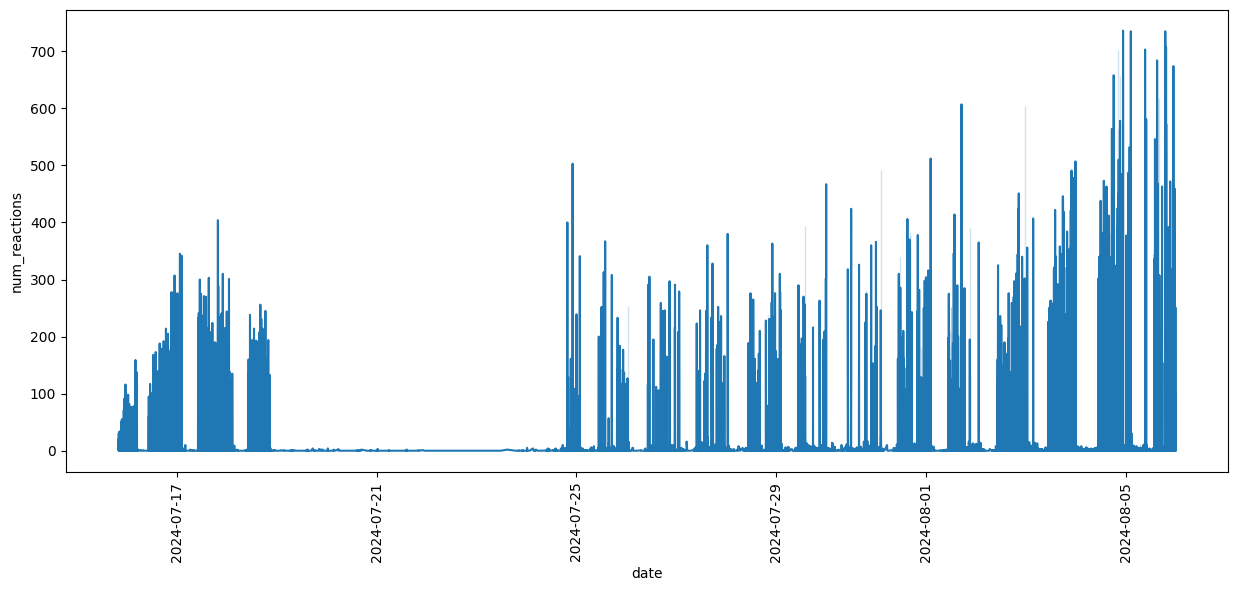

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.lineplot(x=result_df['date'], y=result_df['num_reactions'] )
plt.xticks(rotation=90,)

In [12]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, weighted_corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.101877  0.172901       1        1  41.913134
1     -0.173578 -0.145292       2        1  36.667464
0      0.275455 -0.027609       3        1  21.419402, topic_info=              Term          Freq         Total Category  logprob  loglift
17      media_imag  13193.000000  13193.000000  Default  30.0000  30.0000
34     media_video   6705.000000   6705.000000  Default  29.0000  29.0000
782          হাসিন   2648.000000   2648.000000  Default  28.0000  28.0000
6             ঢাকা   2986.000000   2986.000000  Default  27.0000  27.0000
37615         capt   1408.000000   1408.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
418           দিয়ে    396.575789   2158.457642   Topic3  -5.9565  -0.1534
3657           যাব    334.638599    741.523614   Topic3  -6.1263   0.7452
3             আপনা    387.436742   2957.429261   Topic3  -5.9798  -0.4917
541          পোস্ট    333.353603    836.019457   Topic3  -6.1301   0.6214
619           বন্ধ    313.691547   1178.856571   Topic3  -6.1909   0.2170

[237 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
652        2  0.989854  01626804795
692        2  0.989856  01925582350
181        1  0.006314           10
181        2  0.012628           10
181        3  0.981842           10
...      ...       ...          ...
12959      2  0.027207       হিন্দু
12959      3  0.008592       হিন্দু
59         1  0.545728           হয়
59         2  0.424423           হয়
59         3  0.029973           হয়

[521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [13]:

pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, weighted_corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.101877  0.172901       1        1  41.913086
1     -0.173578 -0.145292       2        1  36.667030
0      0.275455 -0.027609       3        1  21.419884, topic_info=              Term          Freq         Total Category  logprob  loglift
17      media_imag  13193.000000  13193.000000  Default  30.0000  30.0000
34     media_video   6705.000000   6705.000000  Default  29.0000  29.0000
782          হাসিন   2648.000000   2648.000000  Default  28.0000  28.0000
6             ঢাকা   2986.000000   2986.000000  Default  27.0000  27.0000
37615         capt   1408.000000   1408.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
418           দিয়ে    396.584699   2158.462465   Topic3  -5.9565  -0.1534
3657           যাব    334.646117    741.527676   Topic3  -6.1263   0.7452
3             আপনা    387.445446   2957.429363   Topic3  -5.9798  -0.4917
541          পোস্ট    333.361093    836.025582   Topic3  -6.1301   0.6214
619           বন্ধ    313.698594   1178.862302   Topic3  -6.1909   0.2170

[237 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
652        2  0.989865  01626804795
692        2  0.989868  01925582350
181        1  0.006314           10
181        2  0.012628           10
181        3  0.981821           10
...      ...       ...          ...
12959      2  0.027207       হিন্দু
12959      3  0.008592       হিন্দু
59         1  0.545730           হয়
59         2  0.424426           হয়
59         3  0.029973           হয়

[521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [14]:
result_df_subset['text_plain'].str.contains('media_').sum()

6704

In [15]:
len(result_df_subset)

33504

In [16]:
result_df['image_address'].notna().sum()

4934

In [19]:
# result_df['date']
result_df['Text_Emotion']

0        আপডেট পেলে আপনারা গ্রুপে জানিয়ে দিন। \nযারা ঢা...
1        প্লিজ আন্দোলনকারীদের অস্ত্র হাতে নিয়ে নামতে বল...
2                       media_image\n Reactions: 🤬27 😢3 🔥1
3                                          😪 Reactions: 🤬1
4        media_image\nপ্রোফাইল চেঞ্জ করে প্রতিবাদ জানান...
                               ...                        
34202    কারো বাসায়/মন্দিরে/পূজা মন্ডপে/ ধর্মীয় উপাসনাল...
34203    দেশ স্বাধীন করলো শিক্ষিত সমাজ। আর বিজয় উদযাপনে...
34204    Bangladesh er future ki? vote a student ra ki ...
34205    বাংলাদেশ স্বাধীন করার পরে ২টি আইন অবশ্যই সংসদে...
34206    হামলা বাজ্ঞচুর লুটপাট হচ্ছে খুব বেশি।। Reactions:
Name: Text_Emotion, Length: 34207, dtype: object

In [18]:
emoji_df.set_index('id').sum().sort_values(ascending=False)

❤      94732.0
🔥      47716.0
😢      32519.0
👍      24686.0
🤬      20378.0
🫡       1904.0
🖕       1669.0
😭       1308.0
🤣       1307.0
💯        902.0
😁        843.0
👎        443.0
💩        386.0
😱        222.0
❤‍🔥      115.0
👏         97.0
🤡         82.0
🥰         76.0
💔         71.0
🤝         55.0
⚡         53.0
😡         48.0
🤯         32.0
👌         30.0
🎉         25.0
🤔         22.0
🌚         20.0
😐         18.0
😨         17.0
🤮         14.0
🙊         12.0
🤩         12.0
🥴         12.0
😘          8.0
🙏          7.0
🤨          6.0
🕊          6.0
👀          5.0
😍          4.0
🤓          4.0
🙈          3.0
🍌          3.0
🥱          3.0
😎          3.0
💋          1.0
🤷‍♂        1.0
✍          1.0
🤪          1.0
🤷‍♀        1.0
dtype: float64

In [22]:
from openai import OpenAI
from dotenv import load_dotenv
import json
import io
from PIL import Image, ImageOps
import base64

load_dotenv()

def count_openai_embedding_tokens(text: str) -> int:
    """Counts the number of tokens in a text string for OpenAI embedding models."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(text))
    return num_tokens


system_prompt = """You are an expert emotion analysis AI. Your task is to analyze the provided Telegram post and identify the **primary Ekman emotion** expressed.

The Ekman emotions you must choose from are:
- **Anger**: Feeling of antagonism provoked by ill-treatment or opposition.
- **Disgust**: Feeling of revulsion or strong disapproval aroused by something unpleasant or offensive.
- **Fear**: Unpleasant emotion caused by the belief that someone or something is dangerous, likely to cause pain, or a threat.
- **Happiness**: State of well-being and contentment; joy.
- **Sadness**: Emotional pain associated with, or characterized by, feelings of disadvantage, loss, despair, grief, helplessness, disappointment, and sorrow.
- **Surprise**: Feeling caused by something unexpected or unusual.

Please analyze the following telegram post and provide the primary Ekman emtion.

**If the primary emotion doesn't match any of the Ekman emotion then please provide the closest emotion outside the Ekman classification.

If no emotion could be found at all, then please return 'NA'."""

# system_prompt = """You are an expert emotion analysis AI. Your task is to analyze the provided Telegram post and identify the **primary Ekman emotion** expressed.

# The Ekman emotions you must choose from are:
# - **Anger**: Feeling of antagonism provoked by ill-treatment or opposition.
# - **Disgust**: Feeling of revulsion or strong disapproval aroused by something unpleasant or offensive.
# - **Fear**: Unpleasant emotion caused by the belief that someone or something is dangerous, likely to cause pain, or a threat.
# - **Happiness**: State of well-being and contentment; joy.
# - **Sadness**: Emotional pain associated with, or characterized by, feelings of disadvantage, loss, despair, grief, helplessness, disappointment, and sorrow.
# - **Surprise**: Feeling caused by something unexpected or unusual.

# Please analyze the following telegram post and return the dominant Ekman emotion in structured JSON format. If no emotion could be found, then please return 'N/A'. In addition to the emotion label, provide a short explanation for why this emotion was identified.

# Format your output as a valid JSON object with the following fields:
# {
#   "explanation": "<brief explanation (1-2 sentences) of which Ekman emotion is most dominant in the post>"
#   "emotion": "<one of: Anger, Disgust, Fear, Happiness, Sadness, Surprise, N/A>",
# }
# Ensure the output is strictly valid JSON."""


# response_format = {
#     "type": "json_schema",
#     "name": "ekman_emotion",
#     "schema": {
#         "type": "object",
#         "properties": {
#             "emotion": {
#                 "type": "string",
#                 "description": "The primary Ekman emotion expressed in the text.",
#                 "enum": [
#                     "Anger",
#                     "Disgust",
#                     "Fear",
#                     "Happiness",
#                     "Sadness",
#                     "Surprise",
#                     "NA",
#                 ],
#             }
#         },
#         "required": ["emotion"],
#         "additionalProperties": False,
#     },
#     "strict": True,
# }

tool = [
      {
        "type": "function",
        "function": {
          "name": "classify_ekman_emotion",
          "description": "Classify the dominant Ekman emotion from a Telegram post",
          "parameters": {
            "type": "object",
            "properties": {
              "explanation": {
                "type": "string",
                "description": "A brief explanation for which Ekman emotion is dominant"
              },
              "emotion": {
                "type": "string",
                # "enum": [
                #     "Anger",
                #     "Disgust",
                #     "Fear",
                #     "Happiness",
                #     "Sadness",
                #     "Surprise",
                #     "NA",
                # ],
                "description": "The dominant Ekman emotion"
              },
            },
            "required": ["explanation", "emotion"]
          }
        }
      }
    ]

my_texts = ["some text", "Doesn't look fun at all", "some other text", "This is so fun"]

# with open("my_test.jsonl", "w") as f:
#     for i, x in enumerate(my_texts):
#         json.dump(
#             {
#                 "custom_id": f"random_id{i}",
#                 "method": "POST",
#                 "url": "/v1/chat/completions",
#                 "body": {
#                     "model": "gpt-4.1-nano",
#                     "messages": [
#                         {"role": "system", "content": system_prompt},
#                         {"role": "user", "content": x},
#                     ],
#                 "tools":tool,
#                 "tool_choice":'required'
                
#                 },
#             },
#             f,
#         )
#         f.write("\n")

for i in range(0, len(result_df), 1000):
  
  with open(f"discuss_aqd/antiquotadu_discuss_{i}_{i+1000-1}.jsonl", "w") as f:
      for _, row in result_df.iloc[i:i+1000].iterrows():
      # for i, x in enumerate(my_texts):
          if pd.isnull(row['image_address']):
            json.dump(
                {
                    "custom_id": f"antiquotadu_discuss_{row['id']}",
                    "method": "POST",
                    "url": "/v1/chat/completions",
                    "body": {
                        "model": "gpt-4.1-nano",
                        "messages": [
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": row['Text_Emotion']},
                        ],
                    "tools":tool,
                    "tool_choice":'required'
                    
                    },
                },
                f,
            )
          else:
            img = Image.open(row['image_address'])
            
            min_size = min(img.size)
            buffer = io.BytesIO()
            if min_size > 128:
              img_small = ImageOps.scale(img, 128/min_size)
              img_small.save(buffer, format="jpeg")
            else:
              img.save(buffer, format='jpeg')



            encoded_img = base64.b64encode(buffer.getvalue()).decode("utf-8")
            
            json.dump(
                {
                    "custom_id": f"antiquotadu_discuss_{row['id']}",
                    "method": "POST",
                    "url": "/v1/chat/completions",
                    "body": {
                        "model": "gpt-4.1-nano",
                        "messages": [
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": [{"type":"text", "text":row['Text_Emotion']},
                                                        {"type":"image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_img}"}}]},
                        ],
                    "tools":tool,
                    "tool_choice":'required'
                    
                    },
                },
                f,
            )
          f.write("\n")

client = OpenAI()


In [13]:
batch_input_file = client.files.create(
    file=open("antiquotadu.jsonl", "rb"), purpose="batch"
)

print(batch_input_file)

FileObject(id='file-1pCDmqFrQHbrhgJK73FgHo', bytes=8518837, created_at=1751710216, filename='antiquotadu.jsonl', object='file', purpose='batch', status='processed', expires_at=None, status_details=None)


In [14]:
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={"description": "Antiquotadu emotion analysis"},
)

Batch(id='batch_6868fa1cf0b881908fcb0cc8f6ea749f', completion_window='24h', created_at=1751710236, endpoint='/v1/chat/completions', input_file_id='file-1pCDmqFrQHbrhgJK73FgHo', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1751796636, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'Antiquotadu emotion analysis'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [27]:
client.batches.retrieve('batch_6868fa1cf0b881908fcb0cc8f6ea749f')

Batch(id='batch_6868fa1cf0b881908fcb0cc8f6ea749f', completion_window='24h', created_at=1751710236, endpoint='/v1/chat/completions', input_file_id='file-1pCDmqFrQHbrhgJK73FgHo', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1751712477, error_file_id=None, errors=None, expired_at=None, expires_at=1751796636, failed_at=None, finalizing_at=1751711791, in_progress_at=1751710238, metadata={'description': 'Antiquotadu emotion analysis'}, output_file_id='file-JXP7JdbhuntJUw9vK67YEP', request_counts=BatchRequestCounts(completed=1348, failed=0, total=1348))

In [28]:
file_response = client.files.content('file-JXP7JdbhuntJUw9vK67YEP')

In [30]:
my_res_dict = defaultdict(list)

for i in file_response.iter_lines():
    # print(i)
    # break
    my_res_dict['id'].append(int(json.loads(i)['custom_id'].split("_")[-1]))
    j = json.loads(json.loads(i)['response']['body']['choices'][0]['message']['tool_calls'][0]['function']['arguments'])
    try:
        my_res_dict['ekman_emotion'].append(j['emotion'])
    except:
        # print(j)
        my_res_dict['ekman_emotion'].append('NA')
        
    my_res_dict['emotion_explanation'].append(j['explanation'])
    # print(j['emotion'], j['explanation'])

In [31]:
pd.DataFrame(my_res_dict)['ekman_emotion'].value_counts()

ekman_emotion
Happiness                                                                                           432
Anger                                                                                               420
Sadness                                                                                             229
Fear                                                                                                119
NA                                                                                                   92
Surprise                                                                                             27
Disgust                                                                                              25
The dominant emotion expressed in the post is a form of collective distress and call for action.      1
disapproval or worry about the situation.                                                             1
neutral                                           

In [32]:
pd.DataFrame(my_res_dict).to_csv('antiquotadu_emotion.csv', index=False)